# Model Evaluation

This notebook tests the `evaluate_flare` module's model evaluation at the flare event level (i.e. whether it can compute accuracy metrics with respect a model's flare detection) and the `sigma_clip` module's functionality in running a "sigma-clipping" model.

Afterward, it explores feature engineering and data transformation options to enhance the effectiveness of the Isolation Forest model.

## Standard Flares

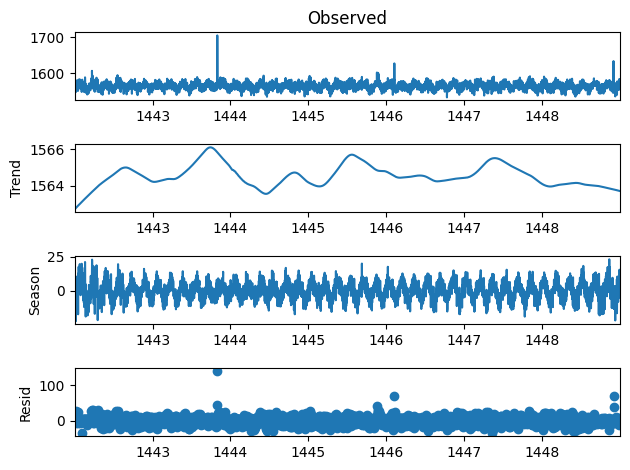

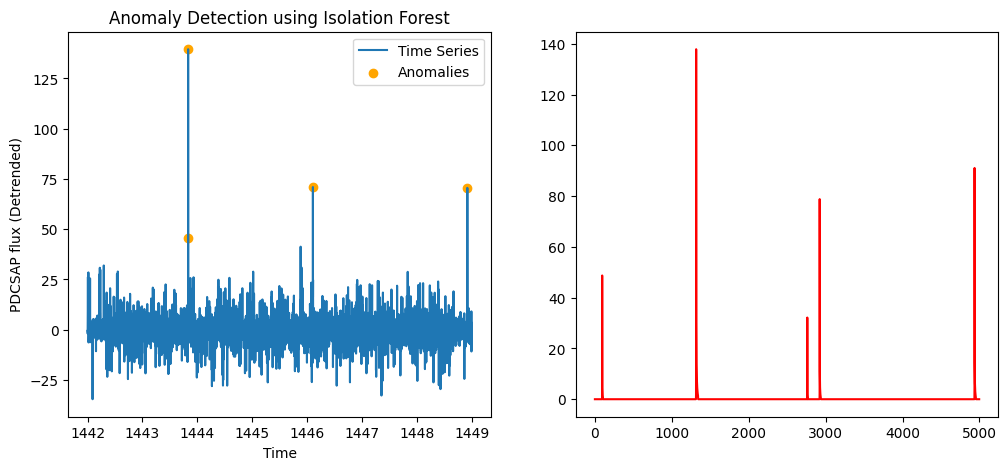

In [11]:
## Load Data
import pandas as pd
inj_std = pd.read_csv("../data/processed/031381302_inj_std.csv", index_col = 'time')
data = inj_std



## STL Decomposition
from statsmodels.tsa.seasonal import STL
stl = STL(data, period=240, robust=True)  # Use period=240 based on EDA
decomposition = stl.fit()
data = decomposition.resid.to_frame()

decomposition.plot()



## Run Model
from sklearn.ensemble import IsolationForest

# Hyperparameters
n_estimators = 100 # Number of trees
contamination = 0.001 # Expected proportion of anomalies
sample_size = 256 # Number of samples used to train each tree

# Isolation Forest
model = IsolationForest(n_estimators = n_estimators, contamination = contamination, max_samples = sample_size)
#contamination = 'auto', random_state = 42)
# random_state: for reproducibility.
# model.fit(data[['resid']].values)
model.fit(data[[data.columns[0]]].values)

# Predict anomalies
anomalies = model.predict(data[[data.columns[0]]].values)
scores = model.decision_function(data[[data.columns[0]]].values)

# Save
data['anomaly'] = anomalies
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})
data['anomaly_score'] = scores



## Plot - Highlight anomalies
import matplotlib.pyplot as plt
import numpy as np

# Simulated Flares
flareSims = np.load("test_flares.npz")

# Anomalies
data_anomalies = data[data['anomaly'] == 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

ax[0].plot(data['resid'], label='Time Series')#, color='steelblue')
ax[0].scatter(data_anomalies.index, data_anomalies['resid'], label='Anomalies', color='orange')
ax[0].set_title('Anomaly Detection using Isolation Forest')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('PDCSAP flux (Detrended)')
ax[0].legend()

ax[1].plot(flareSims["flare_std"], 'r-')

plt.show()

### Results

In [13]:
flareSims["flare_std_times"]

array([[  95,  103],
       [1315, 1341],
       [2762, 2767],
       [2922, 2937],
       [4936, 4953]], dtype=int64)

In [14]:
## Results
import evaluate_flare

# prec, rec, f1 = evaluate_flare.event_level_scores(real_flares=flareSims["flare_std_times"], y_pred=np.where(anomalies == -1, 1, 0))
prec, rec, f1 = evaluate_flare.event_level_scores(real_flares=flareSims["flare_std_times"], y_pred=data["anomaly"].values)
                                               #np.array(data["anomaly"]))
print("Precision =", prec)
print("Recall    =", rec)
print("F1        =", f1)

Precision = 1.0
Recall    = 0.6
F1        = 0.7499999999999999


### Re-plot

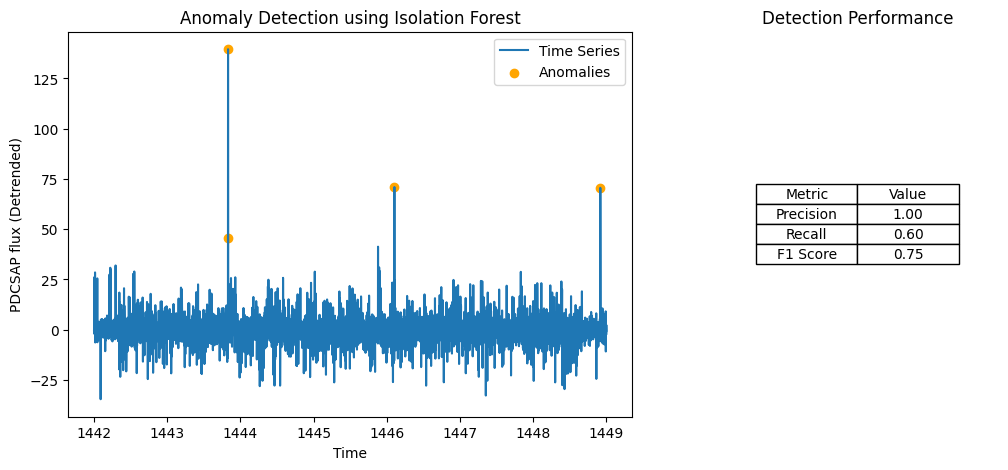

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 1]}) # 1 row, 2 columns

ax[0].plot(data['resid'], label='Time Series')#, color='steelblue')
ax[0].scatter(data_anomalies.index, data_anomalies['resid'], label='Anomalies', color='orange')
ax[0].set_title('Anomaly Detection using Isolation Forest')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('PDCSAP flux (Detrended)')
ax[0].legend()

# ax[1].plot(flareSims["flare_std"], 'r-')
## Results table
results_data = [
    ["Metric", "Value"],
    ["Precision", f"{prec:.2f}"],
    ["Recall", f"{rec:.2f}"],
    ["F1 Score", f"{f1:.2f}"]
]

# Create table in ax[1]
table = ax[1].table(cellText=results_data, loc='center', cellLoc='center', colWidths=[0.3, 0.3])
table.scale(1.2, 1.2)  # scale
ax[1].axis('off')
ax[1].set_title("Detection Performance")

plt.show()

## High-Emission Flares

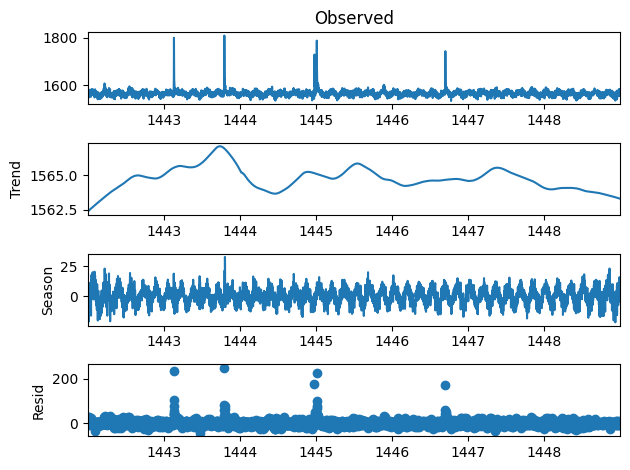

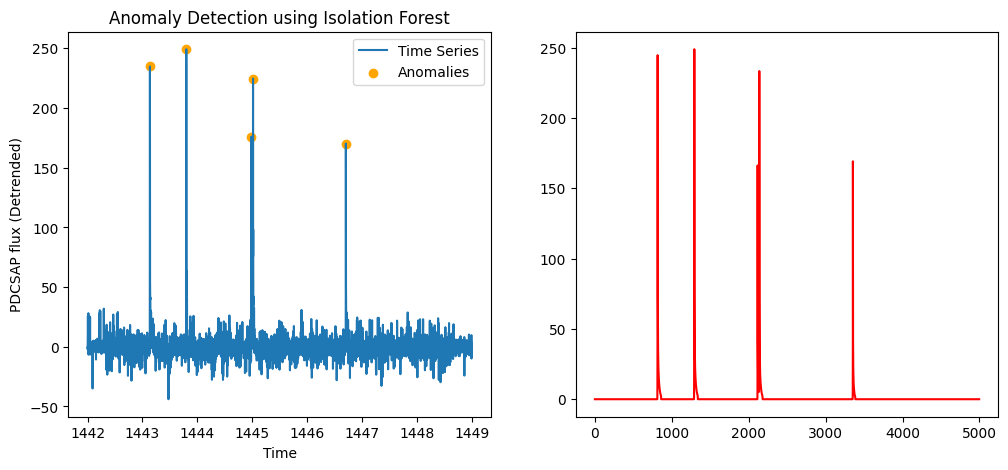

In [5]:
## Load Data
inj_high = pd.read_csv("../data/processed/031381302_inj_high.csv", index_col = 'time')
data = inj_high


## STL Decomposition
from statsmodels.tsa.seasonal import STL
stl = STL(data, period=240, robust=True)  # Use period=240 based on EDA
decomposition = stl.fit()
data = decomposition.resid.to_frame()

decomposition.plot()



## Run Model
from sklearn.ensemble import IsolationForest

# Hyperparameters
n_estimators = 100 # Number of trees
contamination = 0.001 # Expected proportion of anomalies
sample_size = 256 # Number of samples used to train each tree

# Isolation Forest
model = IsolationForest(n_estimators = n_estimators, contamination = contamination, max_samples = sample_size)
#contamination = 'auto', random_state = 42)
# random_state: for reproducibility.
model.fit(data[[data.columns[0]]].values)

# Predict anomalies
anomalies = model.predict(data[[data.columns[0]]].values)
scores = model.decision_function(data[[data.columns[0]]].values)

# Save
data['anomaly'] = anomalies
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})
data['anomaly_score'] = scores



## Plot - Highlight anomalies
import matplotlib.pyplot as plt
import numpy as np

# Simulated Flares
flareSims = np.load("test_flares.npz")

# Anomalies
data_anomalies = data[data['anomaly'] == 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

ax[0].plot(data['resid'], label='Time Series')#, color='steelblue')
ax[0].scatter(data_anomalies.index, data_anomalies['resid'], label='Anomalies', color='orange')
ax[0].set_title('Anomaly Detection using Isolation Forest')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('PDCSAP flux (Detrended)')
ax[0].legend()

ax[1].plot(flareSims["flare_high"], 'r-')

plt.show()

### Results

In [6]:
flareSims["flare_high_times"]
# anomalies

array([[ 812,  860],
       [1289, 1337],
       [2113, 2146],
       [2134, 2179],
       [3352, 3385]], dtype=int64)

In [7]:
## Results
# prec, rec, f1 = evaluate_flare.event_level_scores(real_flares=flareSims["flare_high_times"], y_pred=np.where(anomalies == -1, 1, 0))
prec, rec, f1 = evaluate_flare.event_level_scores(real_flares=flareSims["flare_high_times"], y_pred=np.array(data["anomaly"]))
print("Precision =", prec)
print("Recall    =", rec)
print("F1        =", f1)

Precision = 1.0
Recall    = 1.0
F1        = 1.0


## Low-Emission Flares

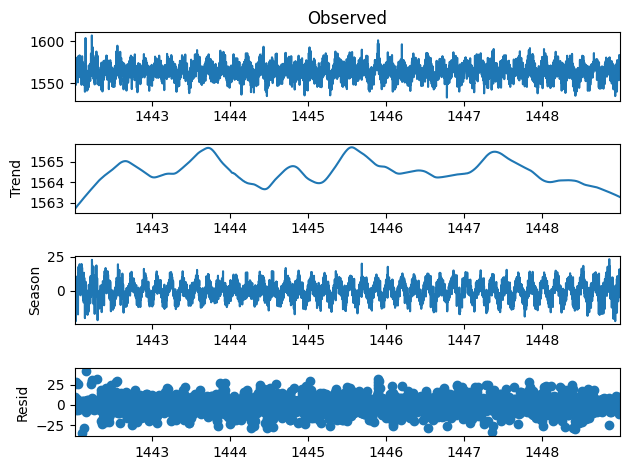

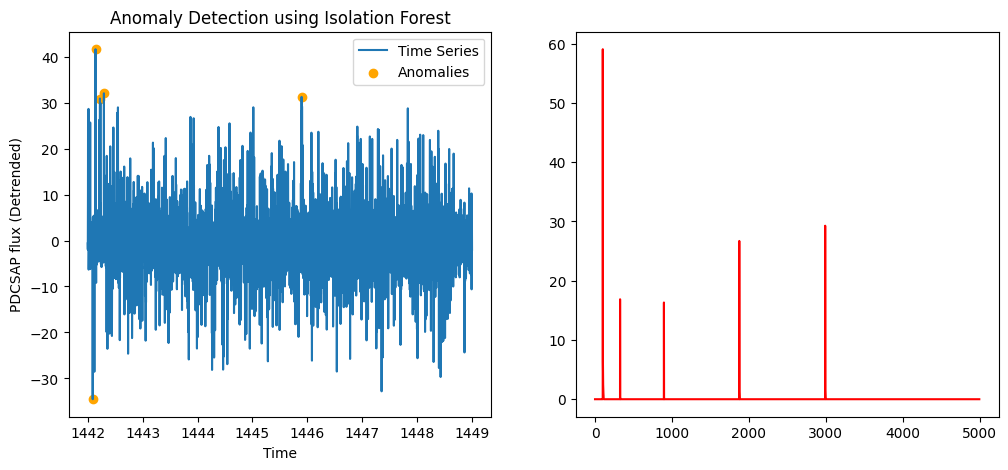

In [8]:
## Load Data
inj_low = pd.read_csv("../data/processed/031381302_inj_low.csv", index_col = 'time')
data = inj_low


## STL Decomposition
from statsmodels.tsa.seasonal import STL
stl = STL(data, period=240, robust=True)  # Use period=240 based on EDA
decomposition = stl.fit()
data = decomposition.resid.to_frame()

decomposition.plot()



## Run Model
from sklearn.ensemble import IsolationForest

# Hyperparameters
n_estimators = 100 # Number of trees
contamination = 0.001 # Expected proportion of anomalies
sample_size = 256 # Number of samples used to train each tree

# Isolation Forest
model = IsolationForest(n_estimators = n_estimators, contamination = contamination, max_samples = sample_size)
#contamination = 'auto', random_state = 42)
# random_state: for reproducibility.
model.fit(data[[data.columns[0]]].values)

# Predict anomalies
anomalies = model.predict(data[[data.columns[0]]].values)
scores = model.decision_function(data[[data.columns[0]]].values)

# Save
data['anomaly'] = anomalies
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})
data['anomaly_score'] = scores



## Plot - Highlight anomalies
import matplotlib.pyplot as plt
import numpy as np

# Simulated Flares
flareSims = np.load("test_flares.npz")

# Anomalies
data_anomalies = data[data['anomaly'] == 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

# ax[0].plot(data['resid'], label='Time Series')#, color='steelblue')
# ax[0].scatter(anomalies.index, anomalies['resid'], label='Anomalies', color='orange')
ax[0].plot(data[data.columns[0]], label='Time Series')
ax[0].scatter(data_anomalies.index, data_anomalies[data.columns[0]], label='Anomalies', color='orange')
ax[0].set_title('Anomaly Detection using Isolation Forest')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('PDCSAP flux (Detrended)')
ax[0].legend()

ax[1].plot(flareSims["flare_low"], 'r-')

plt.show()

### Results

In [9]:
flareSims["flare_low_times"]
# anomalies

array([[ 100,  111],
       [ 326,  329],
       [ 896,  898],
       [1876, 1880],
       [2993, 2998]], dtype=int64)

In [10]:
## Results
# prec, rec, f1 = evaluate_flare.event_level_scores(real_flares=flareSims["flare_low_times"], y_pred=np.where(anomalies == -1, 1, 0))
prec, rec, f1 = evaluate_flare.event_level_scores(real_flares=flareSims["flare_low_times"], y_pred=np.array(data["anomaly"]))
print("Precision =", prec)
print("Recall    =", rec)
print("F1        =", f1)

Precision = 0.2
Recall    = 0.2
F1        = 0.20000000000000004


## Model Function

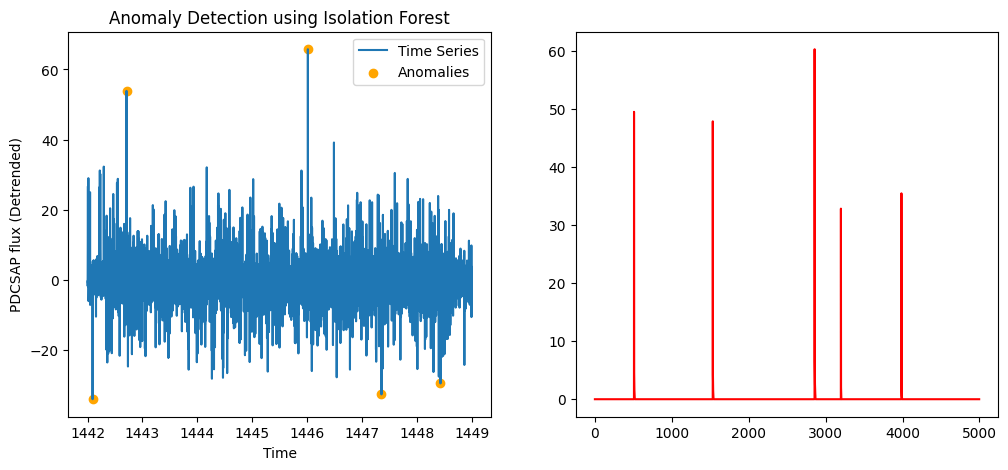

In [11]:
## Load Data
inj_std = pd.read_csv("../data/processed/031381302_inj_std.csv", index_col = 'time')
data = inj_std



## Run Model
from STL_IF import STLIF

data = STLIF(data, contamination=0.001)



## Plot - Highlight anomalies
# Simulated Flares
flareSims = np.load("test_flares.npz")

# Anomalies
data_anomalies = data[data['anomaly'] == 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

ax[0].plot(data[data.columns[0]], label='Time Series')#, color='steelblue')
ax[0].scatter(data_anomalies.index, data_anomalies[data.columns[0]], label='Anomalies', color='orange')
ax[0].set_title('Anomaly Detection using Isolation Forest')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('PDCSAP flux (Detrended)')
ax[0].legend()

ax[1].plot(flareSims["flare_std"], 'r-')

plt.show()

In [12]:
## Results
prec, rec, f1 = evaluate_flare.event_level_scores(real_flares=flareSims["flare_std_times"], y_pred=np.array(data["anomaly"]))
print("Precision =", prec)
print("Recall    =", rec)
print("F1        =", f1)

Precision = 0.4
Recall    = 0.4
F1        = 0.4000000000000001


## Sigma-clipping

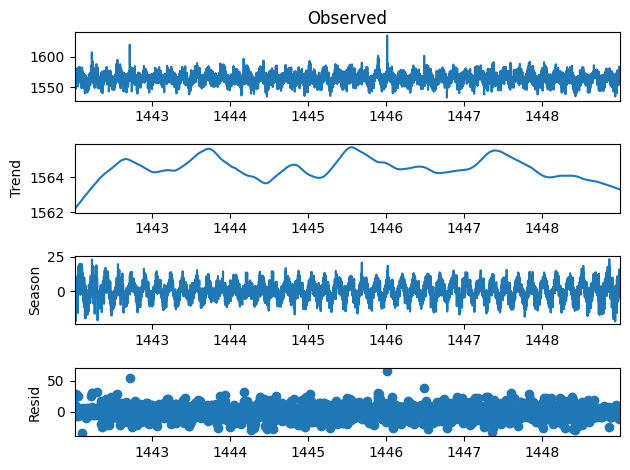

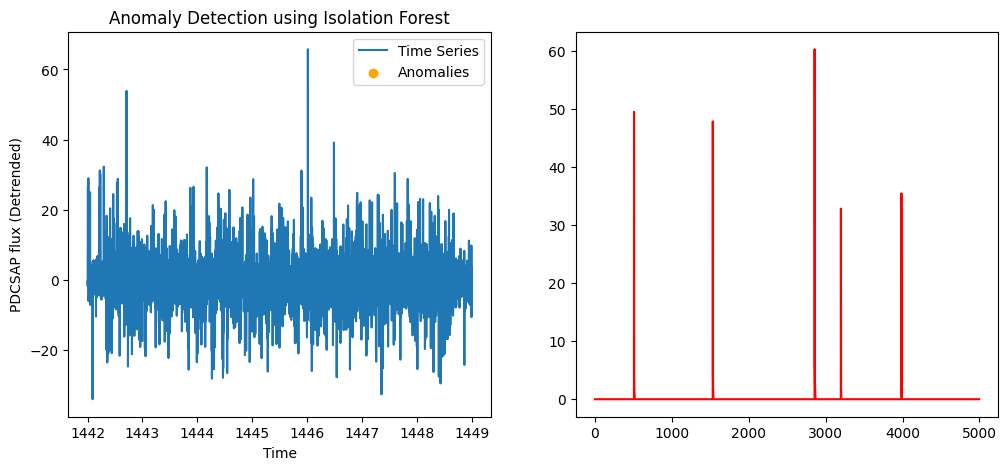

In [13]:
## Re-imports
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

## Load Data
inj_std = pd.read_csv("../data/processed/031381302_inj_std.csv", index_col = 'time')
data = inj_std


## Detrend
stl = STL(data, period=240, robust=True)  # Use period=240 based on EDA
decomposition = stl.fit()
data = decomposition.resid.to_frame()

decomposition.plot()

## Run Model
import importlib
# from sigma_clip import sigma_clip
import sigma_clip
importlib.reload(sigma_clip)

anomalies = sigma_clip.sigma_clip(data, sigma=3.0, consecutive_pts=3)
# data = data.ravel()

# Save
data['anomaly'] = anomalies.ravel()

## Plot - Highlight anomalies
# Simulated Flares
flareSims = np.load("test_flares.npz")

# Anomalies
data_anomalies = data[data['anomaly'] == 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

ax[0].plot(data[data.columns[0]], label='Time Series')#, color='steelblue')
ax[0].scatter(data_anomalies.index, data_anomalies[data.columns[0]], label='Anomalies', color='orange')
ax[0].set_title('Anomaly Detection using Isolation Forest')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('PDCSAP flux (Detrended)')
ax[0].legend()

ax[1].plot(flareSims["flare_std"], 'r-')

plt.show()

In [14]:
## Results
import evaluate_flare
prec, rec, f1 = evaluate_flare.event_level_scores(real_flares=flareSims["flare_std_times"], y_pred=np.array(data["anomaly"]))
print("Precision =", prec)
print("Recall    =", rec)
print("F1        =", f1)

Precision = 0.0
Recall    = 0.0
F1        = 0.0


## Exploration: Feature Engineering + Data Transformations

In [15]:
## Load Data
import pandas as pd
inj_std = pd.read_csv("../data/processed/031381302_inj_std.csv", index_col = 'time')
data = inj_std

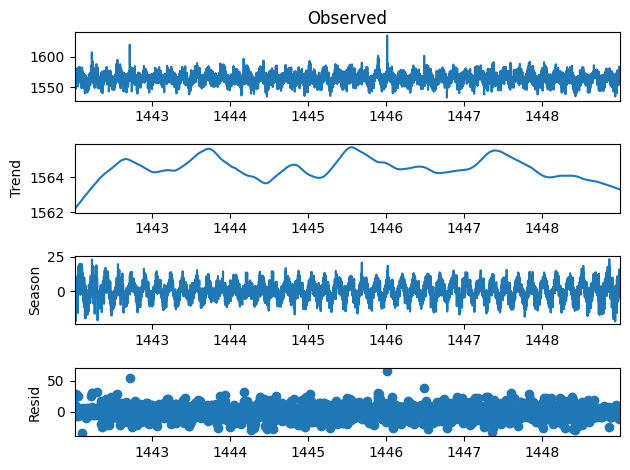

In [16]:
## STL Decomposition
from statsmodels.tsa.seasonal import STL
stl = STL(data, period=240, robust=True)  # Use period=240 based on EDA
decomposition = stl.fit()

decomposition.plot()

# Save
# data = decomposition.resid.to_frame()
# data['resid'] = decomposition.resid
# data['trend'] = decomposition.trend #- decomposition.trend.mean() # Rescale
data['seasonal'] = decomposition.seasonal #+ decomposition.trend.mean() # Rescale
# data['ST'] = decomposition.trend + decomposition.seasonal
data.dropna(inplace=True)

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.copy())
# print(data_scaled)

# data_scaled = pd.DataFrame(data_scaled, columns=['resid', "trend", "seasonal"], index=data.index)
data_scaled = pd.DataFrame(data_scaled, columns=['pdcsap_flux', "seasonal"], index=data.index)
data = data_scaled
data.head()

,pdcsap_flux,seasonal
time,,
1442.000847,0.353980,0.981348
1442.002236,-1.666095,-1.778674
1442.003625,0.449878,0.568868
1442.005014,-0.099275,-1.498350
1442.006402,1.345338,-1.946303


In [18]:
data.describe()
data.info()
# data.head()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4998 entries, 1442.0008468670007 to 1448.9994229398503
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  4998 non-null   float64
 1   seasonal     4998 non-null   float64
dtypes: float64(2)
memory usage: 117.1 KB


C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


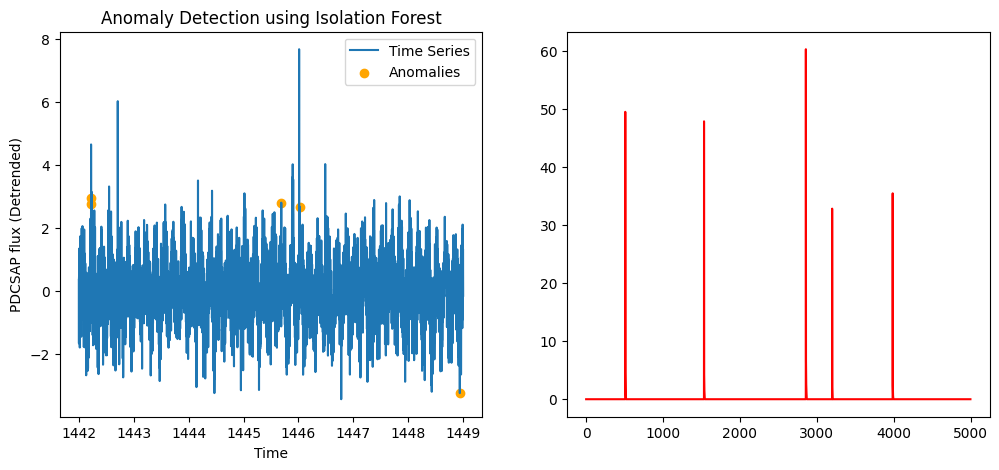

In [19]:
## Run Model
from sklearn.ensemble import IsolationForest

# Hyperparameters
n_estimators = 300 # Number of trees
contamination = 0.001 # Expected proportion of anomalies
sample_size = 256 #"auto" # Number of samples used to train each tree

# Isolation Forest
model = IsolationForest(n_estimators = n_estimators, contamination = contamination, max_samples = sample_size)
#contamination = 'auto', random_state = 42)
# random_state: for reproducibility.
# model.fit(data[['resid']].values)
## Last minute modifications
# data = decomposition.resid.to_frame()
# data['resid'] = data['resid'].clip(lower=0)
model.fit(data)

# Predict anomalies
anomalies = model.predict(data)
scores = model.decision_function(data)

# Save
data['anomaly'] = anomalies
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})
data['anomaly_score'] = scores



## Plot - Highlight anomalies
import matplotlib.pyplot as plt
import numpy as np

# Simulated Flares
flareSims = np.load("test_flares.npz")

# Anomalies
data_anomalies = data[data['anomaly'] == 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

ax[0].plot(data[data.columns[0]], label='Time Series')#, color='steelblue')
ax[0].scatter(data_anomalies.index, data_anomalies[data.columns[0]], label='Anomalies', color='orange')
ax[0].set_title('Anomaly Detection using Isolation Forest')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('PDCSAP flux (Detrended)')
ax[0].legend()

ax[1].plot(flareSims["flare_std"], 'r-')

plt.show()

<AxesSubplot: xlabel='time'>

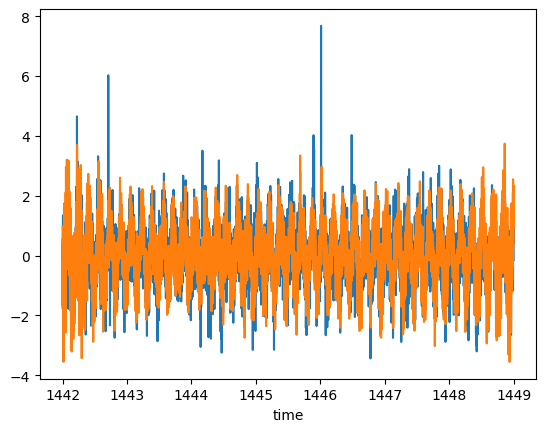

In [20]:
data['pdcsap_flux'].plot()
data['seasonal'].plot()
# data['trend'].plot()

### Results

In [21]:
flareSims["flare_std_times"]

array([[ 509,  517],
       [1533, 1541],
       [2856, 2867],
       [3199, 3204],
       [3986, 3992]], dtype=int64)

In [22]:
## Results
# prec, rec, f1 = evaluate_flare.event_level_scores(real_flares=flareSims["flare_high_times"], y_pred=np.where(anomalies == -1, 1, 0))
prec, rec, f1 = evaluate_flare.event_level_scores(real_flares=flareSims["flare_high_times"], y_pred=np.array(data["anomaly"]))
print("Precision =", prec)
print("Recall    =", rec)
print("F1        =", f1)

Precision = 0.0
Recall    = 0.0
F1        = 0.0
